See Yirang Liu for questions

In [1]:
# load packages
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the data
df = pd.read_csv('https://github.com/ISL-0111/IDS701_Team_Project/raw/refs'
'/heads/main/Experiment_regression/daily_agg_for_ttest_allregions.csv')
df['high_load'] = df['high_load'].astype(int)
df.sample(2)

,courier_id,accept_date,region_id,task_count,avg_delivery_duration_min,avg_distance_km,delivery_hour_mode,high_load,task_count_c,hour_bin,duration_trimmed
31434,2155,2023-06-02,64,2,171.500000,0.408099,9,0,-23,Morning,171.500000
41353,2812,2023-10-14,71,26,115.269231,0.997286,9,1,1,Morning,115.269231


In [ ]:
# Define target group
group_0 = df[df['high_load'] == 0]
group_1 = df[df['high_load'] == 1]

# Get numeric columns excluding 'high_load'
numeric_cols = df.select_dtypes(include='number').columns.drop(
    'high_load')

In [4]:
# Run t-tests
results = []
for col in numeric_cols:
    g0 = group_0[col].dropna()
    g1 = group_1[col].dropna()
    if len(g0) < 2 or len(g1) < 2:
        continue
    t_stat, p_val = ttest_ind(g0, g1, equal_var=False)
    results.append((col, t_stat, p_val))

In [5]:
results

[('courier_id', -0.03645485621251803, 0.9709197960699789),
 ('region_id', 19.765597844086003, 1.1363167567574925e-86),
 ('task_count', -414.90934333397064, 0.0),
 ('avg_delivery_duration_min', 46.66800458865153, 0.0),
 ('avg_distance_km', 0.5433424379861566, 0.586895946710973),
 ('delivery_hour_mode', 14.417279752004992, 4.828294130976965e-47),
 ('task_count_c', -414.90934333397064, 0.0),
 ('duration_trimmed', 46.541134594107504, 0.0)]

In [ ]:
# Create DataFrame
results_df = pd.DataFrame(results, columns=[
    'Feature', 'T-statistic', 'P-value'])

# Avoid log10(0) by adding a really small number
epsilon = 1e-300
results_df['-log10(P-value)'] = -np.log10(results_df['P-value'] 
                                          + epsilon)

# Sort for plot
results_df.sort_values('-log10(P-value)', ascending=False, inplace=True)
results_df

,Feature,T-statistic,P-value,-log10(P-value)
2,task_count,-414.909343,0.000000e+00,300.000000
3,avg_delivery_duration_min,46.668005,0.000000e+00,300.000000
6,task_count_c,-414.909343,0.000000e+00,300.000000
7,duration_trimmed,46.541135,0.000000e+00,300.000000
1,region_id,19.765598,1.136317e-86,85.944501
5,delivery_hour_mode,14.417280,4.828294e-47,46.316206
4,avg_distance_km,0.543342,5.868959e-01,0.231439
0,courier_id,-0.036455,9.709198e-01,0.012817


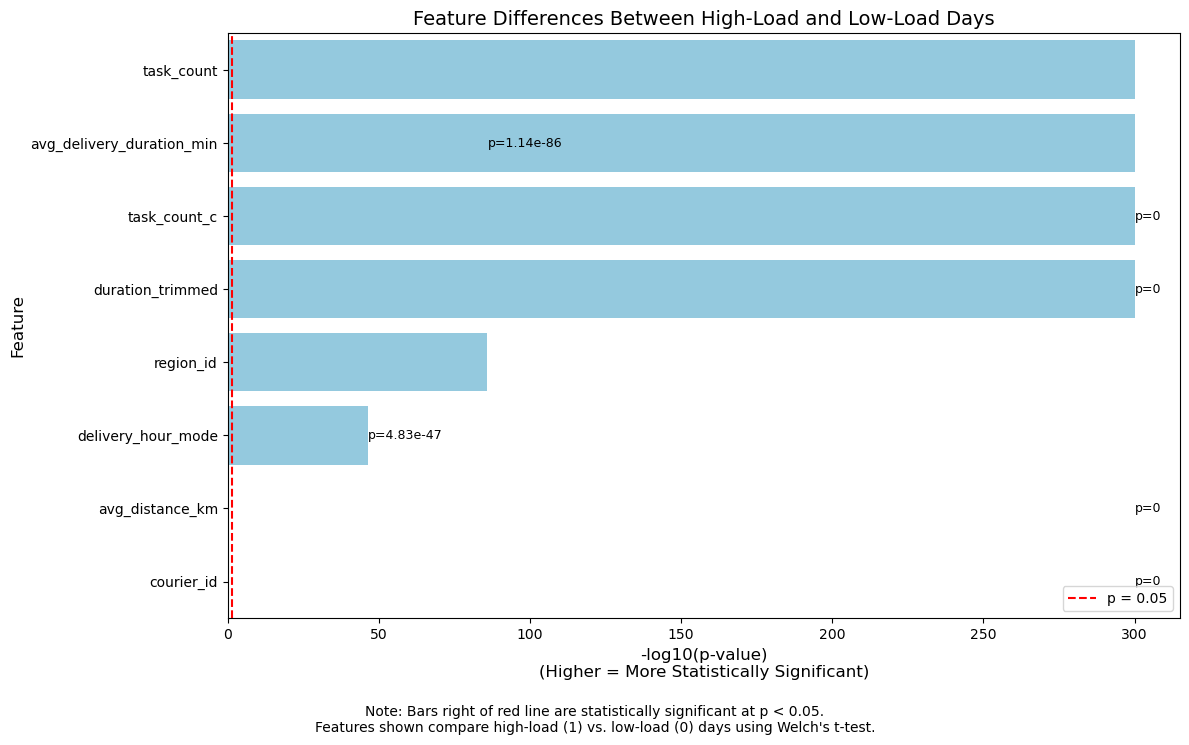

In [ ]:
# --- Plot ---
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=results_df,
    x='-log10(P-value)',
    y='Feature',
    color='skyblue'
)

# Significance threshold line (p = 0.05)
sig_threshold = -np.log10(0.05)
plt.axvline(sig_threshold, color='red', linestyle='--', label='p = 0.05')

# Annotate bars
for i, row in results_df.iterrows():
    if row['-log10(P-value)'] > sig_threshold:
        ax.text(
            row['-log10(P-value)'] + 0.05, i,
            f"p={row['P-value']:.3g}",
            va='center',
            fontsize=9,
            color='black'
        )

# Labels and legend
plt.title('Feature Differences Between High-Load and Low-Load Days', 
          fontsize=14)
plt.xlabel('-log10(p-value)\n(Higher = More Statistically Significant)', 
           fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.legend(loc='lower right')

# Caption
plt.figtext(
    0.5, -0.05,
    "Note: Bars right of red line are statistically significant at p < 0.05.\n"
    "Features shown compare high-load (1) vs. low-load (0) days using Welch's t-test.",
    wrap=True,
    horizontalalignment='center',
    fontsize=10
)

plt.tight_layout()
plt.show()

In [ ]:
# --- Effect size summary ---
summary = []
for col in results_df['Feature']:
    mean_0 = group_0[col].mean()
    mean_1 = group_1[col].mean()
    pct_diff = ((mean_1 - mean_0) / abs(mean_0)
                ) * 100 if mean_0 != 0 else float('nan')
    p_val = results_df.loc[results_df['Feature'] == col, 'P-value'
                           ].values[0]
    
    summary.append({
        'Feature': col,
        'Low Load Mean': mean_0,
        'High Load Mean': mean_1,
        '% Difference': pct_diff,
        'P-value': p_val
    })

summary_df = pd.DataFrame(summary)
summary_df = summary_df.round({
    'Low Load Mean': 2,
    'High Load Mean': 2,
    '% Difference': 1,
    'P-value': 4
})

# Show the effect size summary
print("\nEffect Size Summary:")
print(summary_df.sort_values('P-value'))


Effect Size Summary:
                     Feature  Low Load Mean  High Load Mean  % Difference  \
0                 task_count          11.55           35.75         209.5   
1  avg_delivery_duration_min         122.85           95.94         -21.9   
2               task_count_c         -13.45           10.75         179.9   
3           duration_trimmed         121.80           95.94         -21.2   
4                  region_id          48.99           44.85          -8.4   
5         delivery_hour_mode          12.15           11.78          -3.1   
6            avg_distance_km           2.87            2.79          -2.9   
7                 courier_id        2434.14         2434.53           0.0   

   P-value  
0   0.0000  
1   0.0000  
2   0.0000  
3   0.0000  
4   0.0000  
5   0.0000  
6   0.5869  
7   0.9709  


## Analysis Summary: Impact of High Load on Delivery Metrics

A series of Welch’s t-tests were conducted to compare courier performance metrics between high-load and low-load days. The analysis revealed that several key features significantly differ when the system experiences heavy demand.

Most notably, task count per courier surged by approximately 209% on high-load days, highlighting the substantial increase in operational pressure. Correspondingly, the variability in task counts (task_count_c) showed a similar dramatic rise of 180%, indicating greater inconsistency in workload distribution across couriers. Interestingly, despite the higher task volume, the average delivery duration decreased by nearly 22%, suggesting that couriers completed deliveries more quickly when the system was under strain.

Other significant but less pronounced differences were observed in region_id (−8.4%) and delivery_hour_mode (−3.1%), implying slight shifts in where and when deliveries occurred during high-load periods. In contrast, average delivery distance and courier identity remained statistically unchanged, indicating that the operational adjustments primarily affected task volume and timing, rather than route lengths or workforce composition.

These findings suggest that during high-load events, couriers adapt by accelerating deliveries without significantly increasing travel distance, perhaps through route optimization, batching, or prioritization of tasks.

### Result Summary
- Statistically Significant Features (p < 0.05):
    - task_count (+209.5% on high-load days)
    - avg_delivery_duration_min (−21.9%)
    - task_count_c (+179.9%)
    - duration_trimmed (−21.2%)
    - region_id (−8.4%)
    - delivery_hour_mode (−3.1%)
- Not Significant:
    - avg_distance_km (p = 0.5869)
    - courier_id (p = 0.9709)
- Strongest effects:
    - Task volume (task_count) and completion variance (task_count_c) skyrocketed under high load.
    - Deliveries became faster despite high volume (delivery time dropped ~22%).

### Interpretation
- Operational Pressure leads to:
    - Higher task volume handled per courier.
    - Shorter delivery durations — possibly due to operational optimizations or prioritization.
- No major change in delivery distance or courier identity.
- Practical meaning:
    - During high-load days, couriers are much busier but not traveling significantly farther.
    - Regions and hours slightly shift but not drastically.

### Proposals for Implementation
- Dynamic Task Allocation:
    - Auto-adjust courier assignments based on predicted load to maintain quality.
- Incentivize Efficient Behavior:
    - Shorter delivery times under load suggest performance gains; consider bonus structures linked to efficiency during high load.
- Regional Load Balancing:
    - Minor but significant shifts in region usage; explore proactive rebalancing couriers by region ahead of high-load events.

### Future Work
- Predictive Modeling:
    - Build a model to predict high-load days early using upstream signals (e.g., orders booked, customer activity).
- Further Segmentation:
    - Break down by hour_bin or weekday vs. weekend to find deeper patterns.
- Explore Causality:
    - Conduct controlled A/B experiments: can preemptively optimizing shifts lead to even better delivery times?
- Investigate Courier Behavior:
    - Are faster deliveries due to speed or task bundling strategies?